In [1]:
import torch
import sys
import os
current_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(current_dir, "../../../SPARK"))
sys.path.append(parent_dir)
from utils import *
device = "cuda"
import numpy as np
import matplotlib.pyplot as plt
import os
print("Current working directory:", os.getcwd())
from scipy.ndimage import gaussian_filter


╔═══════════════════════════════════════════════════╗
║                                                   ║
║  ██████╗   ██████╗    ██╗      ██████╗   ██╗  ██╗ ║
║ ██╔════╝  ██╔══██╗   ██╔██╗    ██╔══██╗  ██║ ██╔╝ ║
║ ╚█████╗   ██████╔╝  ██╔╝╚██╗   ██████╔╝  █████╔╝  ║
║  ╚═══██╗  ██╔═══╝  ██╔╝  ╚██╗  ██╔══██╗  ██╔═██╗  ║
║ ██████╔╝  ██║     ██╔╝    ╚██╗ ██║  ██║  ██║ ╚██╗ ║
║ ╚═════╝   ╚═╝     ╚═╝      ╚═╝ ╚═╝  ╚═╝  ╚═╝  ╚═╝ ║
║                                                   ║
║     Statistical Physics Autodiff Research Kit     ║
╚═══════════════════════════════════════════════════╝

          V(r)           ψ, φ              q
           │               │               │
           ○               ○               ○
         ╱ | ╲           ╱ | ╲           ╱ | ╲
        ○  ○  ○         ○  ○  ○         ○  ○  ○
         ╲ | ╱           ╲ | ╱           ╲ | ╱
           ○               ○               ○
           │               │               │
          g(r)             F         

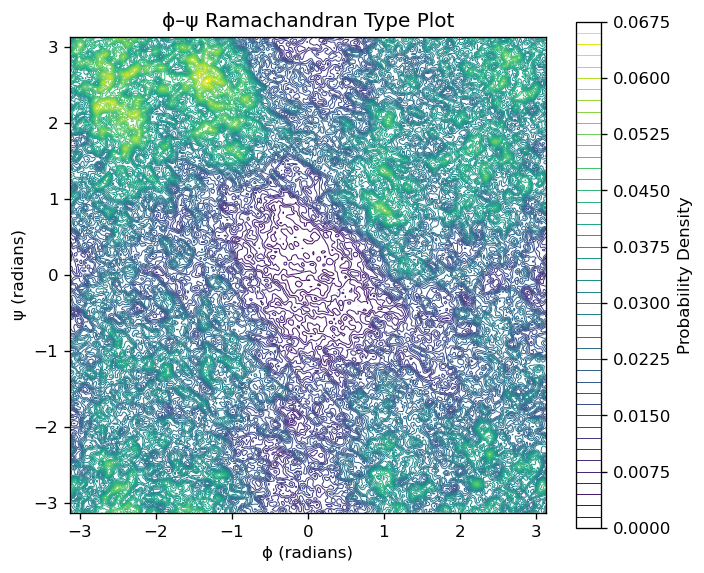

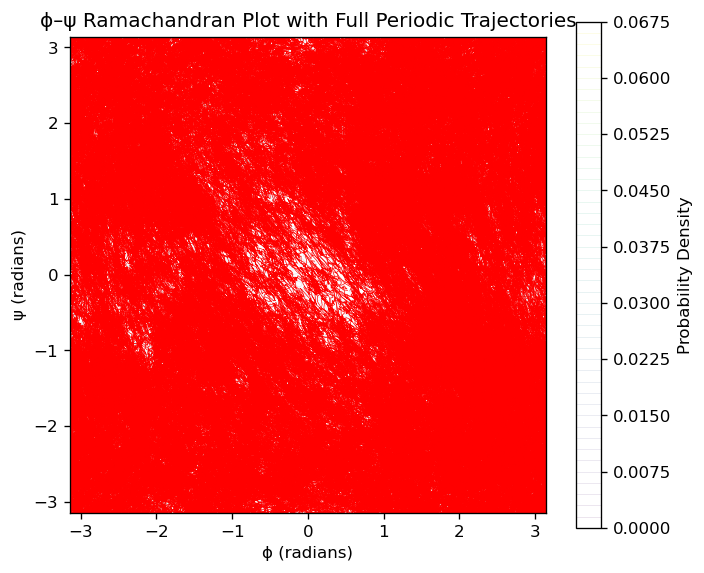

In [3]:
data_path = ""
base_path = f"{data_path}ADP_Vacuum"
pos_path = base_path + "_position"
mom_path = base_path + "_momentum"

position_data = torch.load(pos_path, map_location=device)
momentum_data = torch.load(mom_path, map_location=device)

top, node_features, mass, energy_dict = build_top_and_features("alanine-dipeptide.prmtop")

bins = 300
extent = [-math.pi, math.pi, -math.pi, math.pi]
range_ = [extent[:2], extent[2:]]

# Compute and smooth histogram
dihedrals = compute_dihedrals(position_data, top.get_tensor(4, 'dihtype_6'))  # (T, M, 2)
data = dihedrals.reshape(-1, 2).cpu().numpy()
hist, _, _ = np.histogram2d(data[:, 0], data[:, 1], bins=bins, range=range_, density=True)
hist_smooth = gaussian_filter(hist, sigma=1.0)

# Create clean line contour plot
fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
contours = ax.contour(
    hist_smooth, levels=50, linewidths=0.6, cmap='viridis',
    extent=extent, origin='lower', antialiased=True
)
cb = fig.colorbar(contours, ax=ax, label="Probability Density")

ax.set_xlabel("ϕ (radians)")
ax.set_ylabel("ψ (radians)")
ax.set_title("ϕ–ψ Ramachandran Type Plot")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------#

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)

contours = ax.contour(
    hist_smooth, levels=50, linewidths=0.6, cmap='viridis',
    extent=extent, origin='lower', antialiased=True,alpha=0.1
)
fig.colorbar(contours, ax=ax, label="Probability Density")

traj = dihedrals.cpu().numpy()                 # (T, M, 2)

def plot_wrapped(phi, psi, *, ax, lw=0.4, alpha=1,color='red',tolerance=1.01):
    """
    Draw a continuous 2-D trajectory on the (-π,π]×(-π,π] torus.
    Strategy: unwrap -> tile nine copies -> show only the points that
              fall inside the central box for each tile.
    """
    # continuous path
    phi_u = np.unwrap(phi)
    psi_u = np.unwrap(psi)

    # nine tiles (k,l ∈ {-1,0,1})
    two_pi = 2 * math.pi
    for k in (-1, 0, 1):
        for l in (-1, 0, 1):
            phi_t = phi_u - k * two_pi
            psi_t = psi_u - l * two_pi

            mask  = (phi_t >= -tolerance*math.pi) & (phi_t <=  tolerance*math.pi) \
                  & (psi_t >= -tolerance*math.pi) & (psi_t <=  tolerance*math.pi)
            # keep in-box points, drop the rest with NaNs so segments break
            phi_p = np.where(mask, phi_t, np.nan)
            psi_p = np.where(mask, psi_t, np.nan)
            ax.plot(phi_p, psi_p, lw=lw, alpha=alpha,color=color, zorder=2)

# overlay every dihedral pair
for m in range(5000):
    plot_wrapped(traj[:, m, 0], traj[:, m, 1], ax=ax)

ax.set_xlim(range_[0][0],range_[0][1])
ax.set_ylim(range_[0][0],range_[0][1])
ax.set_xlabel("ϕ (radians)")
ax.set_ylabel("ψ (radians)")
ax.set_title("ϕ–ψ Ramachandran Plot with Full Periodic Trajectories")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

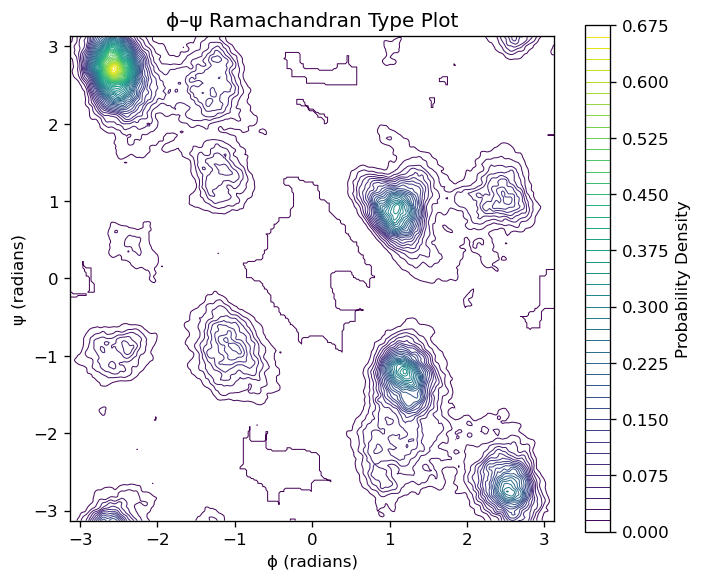

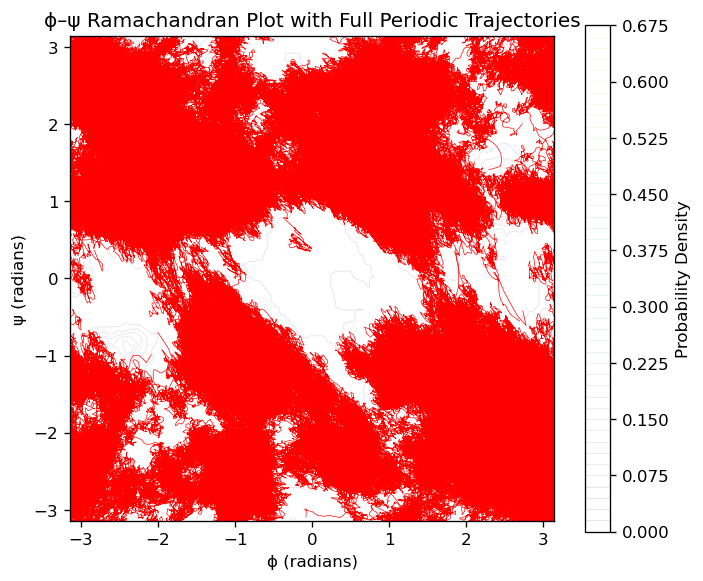

In [4]:
data_path = ""
base_path = f"{data_path}ADP_Vacuum"
pos_path = base_path + "_position_long"
mom_path = base_path + "_momentum_long"

position_data = torch.load(pos_path, map_location=device)
momentum_data = torch.load(mom_path, map_location=device)

top, node_features, mass, energy_dict = build_top_and_features("alanine-dipeptide.prmtop")

bins = 300
extent = [-math.pi, math.pi, -math.pi, math.pi]
range_ = [extent[:2], extent[2:]]

# Compute and smooth histogram
dihedrals = compute_dihedrals(position_data, top.get_tensor(4, 'dihtype_6'))  # (T, M, 2)
data = dihedrals.reshape(-1, 2).cpu().numpy()
hist, _, _ = np.histogram2d(data[:, 0], data[:, 1], bins=bins, range=range_, density=True)
hist_smooth = gaussian_filter(hist, sigma=1.0)

# Create clean line contour plot
fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
contours = ax.contour(
    hist_smooth, levels=50, linewidths=0.6, cmap='viridis',
    extent=extent, origin='lower', antialiased=True
)
cb = fig.colorbar(contours, ax=ax, label="Probability Density")

ax.set_xlabel("ϕ (radians)")
ax.set_ylabel("ψ (radians)")
ax.set_title("ϕ–ψ Ramachandran Type Plot")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------#

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)

contours = ax.contour(
    hist_smooth, levels=50, linewidths=0.6, cmap='viridis',
    extent=extent, origin='lower', antialiased=True,alpha=0.1
)
fig.colorbar(contours, ax=ax, label="Probability Density")

traj = dihedrals.cpu().numpy()                 # (T, M, 2)

def plot_wrapped(phi, psi, *, ax, lw=0.4, alpha=1,color='red',tolerance=1.01):
    """
    Draw a continuous 2-D trajectory on the (-π,π]×(-π,π] torus.
    Strategy: unwrap -> tile nine copies -> show only the points that
              fall inside the central box for each tile.
    """
    # continuous path
    phi_u = np.unwrap(phi)
    psi_u = np.unwrap(psi)

    # nine tiles (k,l ∈ {-1,0,1})
    two_pi = 2 * math.pi
    for k in (-1, 0, 1):
        for l in (-1, 0, 1):
            phi_t = phi_u - k * two_pi
            psi_t = psi_u - l * two_pi

            mask  = (phi_t >= -tolerance*math.pi) & (phi_t <=  tolerance*math.pi) \
                  & (psi_t >= -tolerance*math.pi) & (psi_t <=  tolerance*math.pi)
            # keep in-box points, drop the rest with NaNs so segments break
            phi_p = np.where(mask, phi_t, np.nan)
            psi_p = np.where(mask, psi_t, np.nan)
            ax.plot(phi_p, psi_p, lw=lw, alpha=alpha,color=color, zorder=2)

# overlay every dihedral pair
for m in range(64):
    plot_wrapped(traj[:, m, 0], traj[:, m, 1], ax=ax)

ax.set_xlim(range_[0][0],range_[0][1])
ax.set_ylim(range_[0][0],range_[0][1])
ax.set_xlabel("ϕ (radians)")
ax.set_ylabel("ψ (radians)")
ax.set_title("ϕ–ψ Ramachandran Plot with Full Periodic Trajectories")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [5]:
base_path = f"{data_path}ADP_Vacuum"
pos_path = base_path + "_position"
mom_path = base_path + "_momentum"

position_data = torch.load(pos_path, map_location=device)
momentum_data = torch.load(mom_path, map_location=device)


Kept 16357 / 16384 trajectories.


In [6]:
momentum_data.size()

torch.Size([200, 16384, 22, 3])

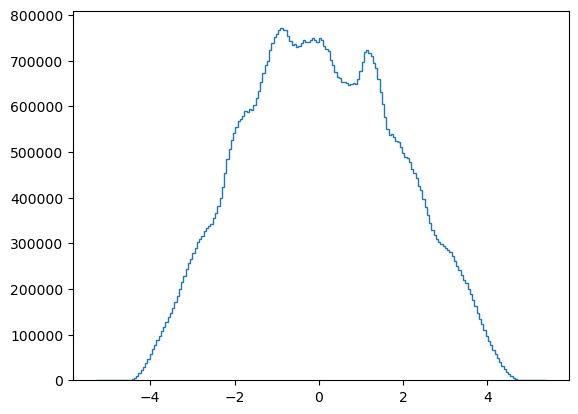

In [15]:
plt.hist(position_data[:,:,:,1].flatten().cpu(),bins=200,histtype='step')
plt.show()